# Training of vision model to identify the 100 selected plant species


In [1]:
from fastai.vision.all import *
import timm
import torch

/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Define directories
data_dir = Path("../data")
img_dir = data_dir/"images_preproc"
model_dir = data_dir/"model"

In [3]:
len(get_image_files(img_dir))

24721

In [4]:
#Define function to get dataloader with different image and batch size
def get_dls(bs, size):
    dl = ImageDataLoaders.from_folder(
        path = img_dir, 
        valid_pct = 0.2, 
        bs = bs, 
        item_tfms = Resize(460),
        batch_tfms = aug_transforms(mult=2,size=size, min_scale=0.25))
    return(dl)

In [5]:
#Get dataloader with lower resolution images for first round of training
#Second round of training will use higher resolution images (progressive resizing)
dls = get_dls(64, 300)

In [6]:
#Use model from the timm library
#Here we use a pretrained light-weight efficientnet
learn = vision_learner(dls, 
                       "efficientnet_b0",
                       pretrained=True,
                       normalize=True,
                       cbs=[MixUp(1.)],
                       loss_func=LabelSmoothingCrossEntropy(), #CrossEntropyLossFlat
                       metrics=[accuracy, top_k_accuracy]).to_fp16()

In [7]:
#plantnet weights
#https://github.com/plantnet/PlantNet-300K/blob/main/utils.py
plantnet = torch.load(model_dir/"efficientnet_b0_weights_best_acc.tar", map_location="cpu")
plantnet_state_dict = plantnet["model"]
plantnet_state_dict.pop('classifier.weight')
plantnet_state_dict.pop('classifier.bias')

#replace names in state_dict
new_state_dict = OrderedDict()

for k, v in plantnet_state_dict.items():
    name = "model."+k
    new_state_dict[name] = v

#update learner model weights
learn.model[0].load_state_dict(new_state_dict)


<All keys matched successfully>

In [8]:
#First round of training
learn.fine_tune(5, 2e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.353256,2.549418,0.488269,0.763956,01:22
1,3.747468,2.241548,0.568770,0.832524,01:21


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.470524,2.087260,0.619539,0.858617,01:33
1,3.367707,2.080462,0.626214,0.859830,01:33
2,3.259723,1.940132,0.673341,0.885518,01:33
3,3.203641,1.906380,0.679005,0.888754,01:33
4,3.148422,1.886141,0.690129,0.892799,01:33


In [9]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.138714,1.893849,0.684466,0.893002,01:33
1,3.141174,1.865731,0.692557,0.896036,01:33
2,3.134319,1.894939,0.683050,0.892193,01:33
3,3.118098,1.860572,0.692152,0.898867,01:34
4,3.125817,1.880722,0.687095,0.895429,01:35


In [11]:
#Save model
learn.path = model_dir
learn.export("effnet_b0_16122022.export")

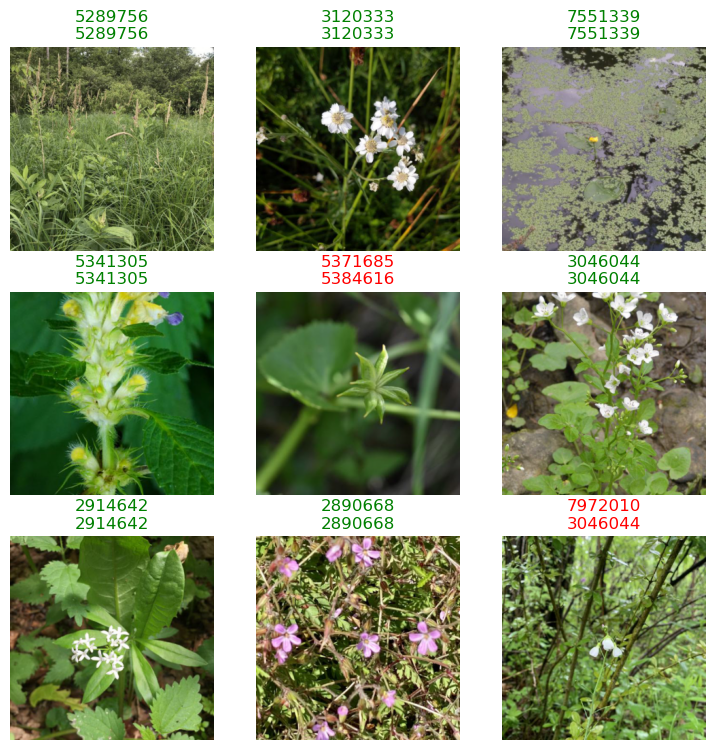

In [12]:
#Show example classifications
learn.show_results()

In [13]:
#export using onnx
from torchvision import transforms

model_fit = load_learner(model_dir/"effnet_b0_16122022.export")

In [14]:
x, y, z = model_fit.predict("/media/kenneth/d6c13395-8492-49ee-9c0f-6a165e34c95c1/dvpi_app/data/images_preproc/2701261/2701261_16.jpeg")
print(x)
print(y)
print(z)
print(z[y])

2701261
TensorBase(1)
TensorBase([1.7385e-03, 5.8677e-01, 2.3386e-01, 5.4034e-03, 8.0556e-04,
            2.6195e-03, 8.4148e-04, 1.1043e-03, 9.4271e-03, 5.7999e-03,
            9.5566e-03, 1.8224e-02, 3.3300e-03, 2.7931e-04, 2.9996e-04,
            8.5115e-04, 8.1600e-03, 4.2847e-03, 2.3849e-03, 2.0732e-04,
            2.8434e-03, 1.3582e-04, 6.5369e-04, 5.6320e-04, 4.7375e-04,
            3.9777e-04, 8.7020e-05, 2.4203e-04, 1.0061e-03, 1.0512e-03,
            5.3259e-04, 1.5509e-04, 2.3517e-03, 1.7715e-03, 1.4657e-03,
            6.7655e-04, 6.3882e-04, 2.6605e-04, 5.4299e-04, 4.1061e-04,
            1.4847e-03, 2.2426e-03, 2.5294e-04, 9.2889e-04, 8.5032e-04,
            4.4536e-03, 2.4211e-04, 4.5068e-04, 8.3739e-04, 6.6396e-04,
            3.9215e-04, 8.3281e-04, 3.3340e-04, 7.0164e-04, 4.4411e-04,
            8.2506e-04, 4.1918e-03, 1.0346e-03, 5.0403e-04, 7.9223e-04,
            3.3125e-04, 2.5912e-04, 3.8355e-04, 4.3635e-04, 3.1786e-04,
            1.7719e-04, 2.3677e-04, 2.1186

In [17]:
#export classes
with open(data_dir/'classes.txt', 'w') as output:
    for i in list(model_fit.dls.vocab):
        output.write(str(i) + '\n')


In [18]:
#norm not applied for timm models in fastai??? ONLY IF PRETRAINED = FALSE
#see also https://www.youtube.com/watch?v=bk2ylRhka_8&t=300s

#define normalization layer
normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_model = model_fit.model.cpu()

#define softmax layer
softmax_layer = torch.nn.Softmax(dim=1) 

#assemble the final model
final_model = nn.Sequential(normalization_layer, torch_model, softmax_layer).eval()


In [19]:
final_model

Sequential(
  (0): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (1): Sequential(
    (0): TimmBody(
      (model): EfficientNet(
        (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (blocks): Sequential(
          (0): Sequential(
            (0): DepthwiseSeparableConv(
              (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (bn1): BatchNormAct2d(
                32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): SiLU(inplace=True)
              )
              (se): SqueezeExcite(
                (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (act1): SiLU

In [22]:
final_model(x_trans)

TensorBase([[3.2961e-03, 5.9311e-01, 2.8908e-01, 1.2285e-03, 4.5134e-04,
             2.2914e-03, 5.0000e-04, 3.6891e-04, 9.4094e-04, 2.5123e-03,
             1.3768e-03, 1.7176e-02, 1.7180e-03, 1.2533e-04, 2.2386e-04,
             4.6128e-04, 2.4061e-03, 4.9704e-03, 2.6975e-03, 8.8652e-05,
             2.5369e-04, 8.7877e-05, 2.7170e-04, 7.3861e-04, 1.5535e-04,
             1.0501e-04, 3.9296e-05, 2.2348e-04, 9.0471e-04, 2.2741e-04,
             4.1947e-04, 1.0142e-04, 9.0002e-04, 1.1733e-03, 4.3224e-04,
             4.3469e-04, 9.3595e-04, 4.5741e-04, 1.3566e-04, 1.5984e-04,
             7.6802e-04, 5.8805e-04, 1.5917e-04, 1.0056e-03, 6.7057e-04,
             1.3680e-03, 2.6297e-04, 6.7767e-04, 8.8699e-04, 1.9333e-04,
             1.6671e-04, 3.4124e-04, 1.6538e-04, 6.3006e-04, 7.0952e-04,
             6.5693e-04, 3.3013e-03, 6.3972e-04, 1.5364e-04, 5.4567e-04,
             3.6397e-04, 8.5531e-05, 5.3469e-05, 4.5751e-04, 2.4993e-04,
             1.4873e-04, 9.9549e-05, 1.2537e-04, 4.

In [23]:
dummy_input = torch.randn(1, 3, 300, 300, requires_grad=True)

final_model(dummy_input)

TensorBase([[0.0057, 0.0120, 0.0029, 0.0044, 0.0114, 0.0102, 0.0092, 0.0090,
             0.0040, 0.0163, 0.0087, 0.0025, 0.0069, 0.0045, 0.0817, 0.0029,
             0.0025, 0.0180, 0.0039, 0.0066, 0.0100, 0.0026, 0.0061, 0.0094,
             0.0020, 0.0062, 0.0029, 0.0017, 0.0049, 0.0101, 0.0041, 0.0020,
             0.0075, 0.0044, 0.0032, 0.0078, 0.0076, 0.0019, 0.0029, 0.0037,
             0.0039, 0.0093, 0.0032, 0.0064, 0.0057, 0.0053, 0.0011, 0.0071,
             0.0013, 0.0069, 0.0027, 0.0022, 0.0056, 0.0125, 0.0161, 0.0120,
             0.0214, 0.0071, 0.0074, 0.0390, 0.0024, 0.0141, 0.0115, 0.0130,
             0.0119, 0.0048, 0.0033, 0.0023, 0.0124, 0.0044, 0.0143, 0.0070,
             0.0106, 0.0032, 0.0015, 0.0035, 0.0081, 0.0121, 0.0181, 0.0183,
             0.0191, 0.0038, 0.0025, 0.0078, 0.0053, 0.0163, 0.0097, 0.0106,
             0.0054, 0.0025, 0.0091, 0.0886, 0.0039, 0.0013, 0.0033, 0.0360,
             0.0267, 0.0532, 0.0105, 0.0068]], grad_fn=<AliasBackward0>)

In [24]:

onnx_model_path = model_dir/"effnet_b0_16122022.onnx"

torch.onnx.export(
    final_model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output']
)

In [25]:
from torchvision.io import read_image
import onnxruntime as ort
import numpy as np

In [26]:
x = read_image("/media/kenneth/d6c13395-8492-49ee-9c0f-6a165e34c95c1/dvpi_app/data/images_preproc/2701261/2701261_16.jpeg")
trans = transforms.Compose([transforms.Resize(460), transforms.CenterCrop(300)])
x_trans = (trans(x/255.0)).unsqueeze(0)

In [27]:
ses = ort.InferenceSession(str(onnx_model_path))

In [28]:
out = ses.run(None, {"input": x_trans.numpy()})

In [30]:
out

[array([[3.29608284e-03, 5.93109429e-01, 2.89078981e-01, 1.22850412e-03,
         4.51335829e-04, 2.29135877e-03, 5.00005088e-04, 3.68907436e-04,
         9.40936559e-04, 2.51226220e-03, 1.37675449e-03, 1.71761718e-02,
         1.71799981e-03, 1.25326405e-04, 2.23862648e-04, 4.61276621e-04,
         2.40608584e-03, 4.97037219e-03, 2.69752950e-03, 8.86522685e-05,
         2.53685459e-04, 8.78770152e-05, 2.71702884e-04, 7.38615694e-04,
         1.55351314e-04, 1.05008650e-04, 3.92955262e-05, 2.23475479e-04,
         9.04709043e-04, 2.27411816e-04, 4.19468968e-04, 1.01423437e-04,
         9.00018495e-04, 1.17330090e-03, 4.32239234e-04, 4.34690999e-04,
         9.35947057e-04, 4.57415968e-04, 1.35662354e-04, 1.59840769e-04,
         7.68016849e-04, 5.88053896e-04, 1.59167670e-04, 1.00555632e-03,
         6.70571288e-04, 1.36802148e-03, 2.62967777e-04, 6.77669421e-04,
         8.86991213e-04, 1.93325846e-04, 1.66709127e-04, 3.41235980e-04,
         1.65383855e-04, 6.30057009e-04, 7.09520886

In [29]:
np.argmax(out)

1